# Simulation of a M/M/1 queue

In [1]:
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

def MM1_queue(arrival_rate, service_rate, initial_queue_size=0, how_many=10000):
    # vector of waiting times
    W = np.zeros(how_many)
    # iterarrival times
    int_times = np.random.exponential(scale=1 / arrival_rate, size=how_many)
    # service time
    serv_times = np.random.exponential(scale = 1 / service_rate, size=how_many)
    # setup
    W[0] = sum(np.random.exponential(scale = 1 / service_rate, size = initial_queue_size))
    for i in range(1,how_many):
        W[i] = max(0, W[i-1] + serv_times[i] - int_times[i])
    return W

def plot_acf_custom(data, lags):
    plot_acf(data, lags=lags)
    plt.xlabel('Lag')
    plt.ylim([0,1.1])
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Function (ACF)')
    plt.grid(True)
    plt.show()


## Let's play with some statistics
Let us consider the verage waiting times

In [3]:
arrival_rate = 1 # λ (lambda)
service_rate = 1.1 # μ (mu)
# theoretical average waiting times:
theoretical_waiting_time = 1 / (service_rate- arrival_rate) - 1 / service_rate
print(f"theoretical value: {theoretical_waiting_time}")
print("some average values:")
np.random.seed(1)
for i in range(5):
    print(f"\t {np.mean(MM1_queue(arrival_rate, service_rate))}")

theoretical value: 9.090909090909083
some average values:
	 9.366664386128978
	 9.670540410461696
	 7.165872827425765
	 8.418167030555065
	 8.478375240309598


We compute $\bar{W}_1, \dots, \bar{W}_5$. But the information of the average is poor. 

Let's see if we can grasp something more using the confidence intervals.

In [3]:
confidence_level = 0.95
n_reps = 100
count = 0
z = stats.norm.ppf((1 + confidence_level) / 2)
np.random.seed(1)
for i in range(n_reps):
    data = MM1_queue(arrival_rate, service_rate)
    mu = np.mean(data)
    sigma = np.std(data)
    # print(f"[{mu - z*sigma/math.sqrt(len(data))} - {mu + z*sigma/math.sqrt(len(data))}]")
    if (mu - z*sigma/math.sqrt(len(data)) < theoretical_waiting_time) and (theoretical_waiting_time < mu + z*sigma/math.sqrt(len(data))):
        count += 1
print(f"Real confidence: {count/n_reps}")

Real confidence: 0.12


Why it does not work?


It does not work due to correlation: The standard deviation of the sample mean can be written as $\frac{\sigma}{\sqrt{N}}$ only under the assumption of independence (actually lack of correlation is enough).

How to check it?

- Autocorrelation Function (ACF) quantifies how a time series is related to its own previous values (i.e., at different time lags).
- ACF is useful to understand how observations at earlier time points influence later observations.
- The ACF at lag \( k \) is computed using the formula:


$$ \text{ACF}(k) = \frac{\sum_{t=1}^{N-k} (x_t - \bar{x})(x_{t+k} - \bar{x})}{\sum_{t=1}^{N} (x_t - \bar{x})^2} $$

where $x_t$ is the value at time $t$, $\bar{x}$ is the mean of the series, and $k$ is the lag.


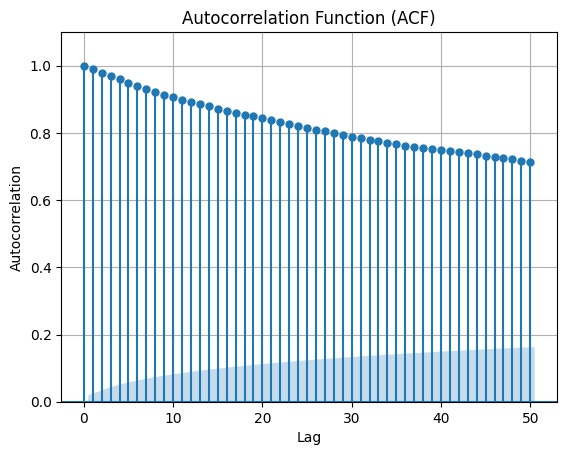

In [4]:
plot_acf_custom(data, lags=50)

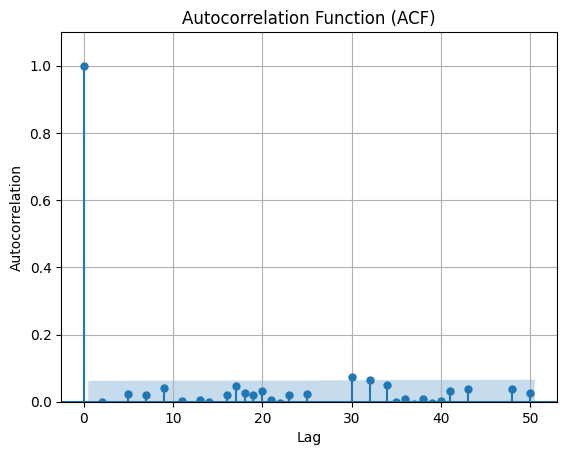

In [5]:
# ACF of independent data
plot_acf_custom(np.random.uniform(low=0.0, high=1.0, size=1000), lags=50)

Let's come back to the slides...

## Convergence to steady state distribution

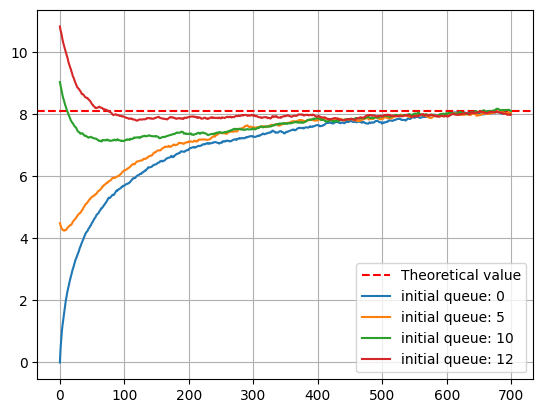

In [30]:
arrival_rate = 1 # λ (lambda)
service_rate = 10 / 9 # μ (mu)
theoretical_waiting_time = 1/(service_rate- arrival_rate) - 1 / service_rate
plt.axhline(y=theoretical_waiting_time, color='r', linestyle='--', label='Theoretical value')

n_reps = 10000
max_person = 700
for initial_queue_size in [0, 5, 10, 12]:    
    # waiting_times contains in each row a possible realization of waiting times
    waiting_times = np.zeros((n_reps, max_person))
    for i in range(n_reps):
        waiting_times[i, :] = MM1_queue(
            arrival_rate, service_rate,
            initial_queue_size = initial_queue_size,
            how_many = max_person
        )
    plt.plot(np.average(waiting_times, axis=0), label=f"initial queue: {initial_queue_size}")
plt.legend()
plt.grid()
plt.show()

It converges faster with 12 than with 0. But

In [7]:
rho = arrival_rate / service_rate
print(f"Average number of people in the queue: {rho / (1 - rho):.2f}")

Average number of people in the queue: 9.00


# Welch algorithm

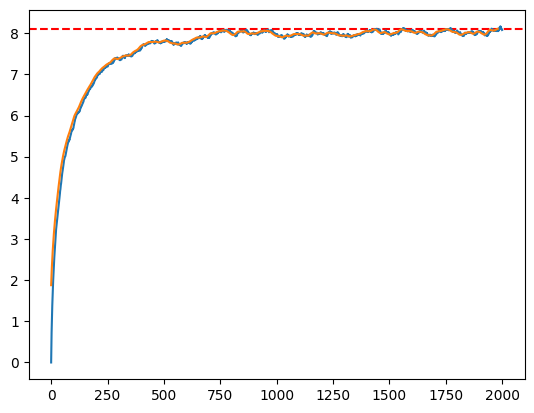

In [29]:
n_reps = 10000
max_person = 2000

waiting_times = np.zeros((n_reps, max_person))
for i in range(n_reps):
    waiting_times[i, :] = MM1_queue(
        arrival_rate, service_rate,
        initial_queue_size = 0,
        how_many = max_person
    )
        
average_process = np.average(waiting_times, axis=0)
# Moving average window size
window_size = 20
# Compute the moving average using np.convolve
moving_average = np.convolve(average_process, np.ones(window_size)/window_size, mode='valid')
plt.axhline(y=theoretical_waiting_time, color='r', linestyle='--', label='Theoretical value')
plt.plot(average_process)
plt.plot(moving_average)
plt.show()